## Dataset: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

In [2]:
# CSS style setting
!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [3]:
#os lobs
import os 
import itertools
import shutil
from PIL import Image
# Data Handling libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
# DeepLearning Tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Activation , Flatten , BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

2024-02-06 23:36:25.069512: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 23:36:25.069638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 23:36:25.325463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Preparation

In [4]:
dataset = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

filepaths = []
labels = []
folds= os.listdir(dataset)

for fold in folds:
    f_path = os.path.join(dataset , fold)
    
    if not os.path.isdir(f_path): # if not a directory, skip
        continue
    imgs = os.listdir(f_path)
    
    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepaths.append(img_path)
        labels.append(fold)
        
Files = pd.Series(filepaths , name= 'filepaths')
labels = pd.Series(labels ,name = 'labels' )
df = pd.concat([Files , labels] , axis = 1)

In [5]:
df.head()

,filepaths,labels
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


In [6]:
class_names = df['labels'].unique().tolist()
class_names

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

## Data Splitting

In [7]:
train , dummy = train_test_split(df , train_size = 0.7 , random_state= 42 , shuffle = True)
valid , test = train_test_split(dummy , test_size = 0.5 , random_state = 42 , shuffle= True)

In [8]:
print(f"The shape of the train data is: {train.shape}")
print(f"The shape of the validation data is: {valid.shape}")
print(f"The shape of the test data is: {test.shape}")

The shape of the train data is: (52500, 2)
The shape of the validation data is: (11250, 2)
The shape of the test data is: (11250, 2)


## Image Data Generator

In [9]:
img_size = (150,150)
channels = 3
num_batches= 64

tr_gen= ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train, x_col= 'filepaths', y_col= 'labels',target_size= img_size, 
                                     class_mode= 'categorical',color_mode= 'rgb', shuffle= True, batch_size= num_batches)
valid_gen= ts_gen.flow_from_dataframe(valid, x_col= 'filepaths', y_col= 'labels',target_size= img_size, 
                                     class_mode= 'categorical',color_mode= 'rgb', shuffle= True, batch_size= num_batches)
test_gen= ts_gen.flow_from_dataframe(test, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False , batch_size= num_batches)

Found 52500 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.
Found 11250 validated image filenames belonging to 5 classes.


## Show Sample From Train Data

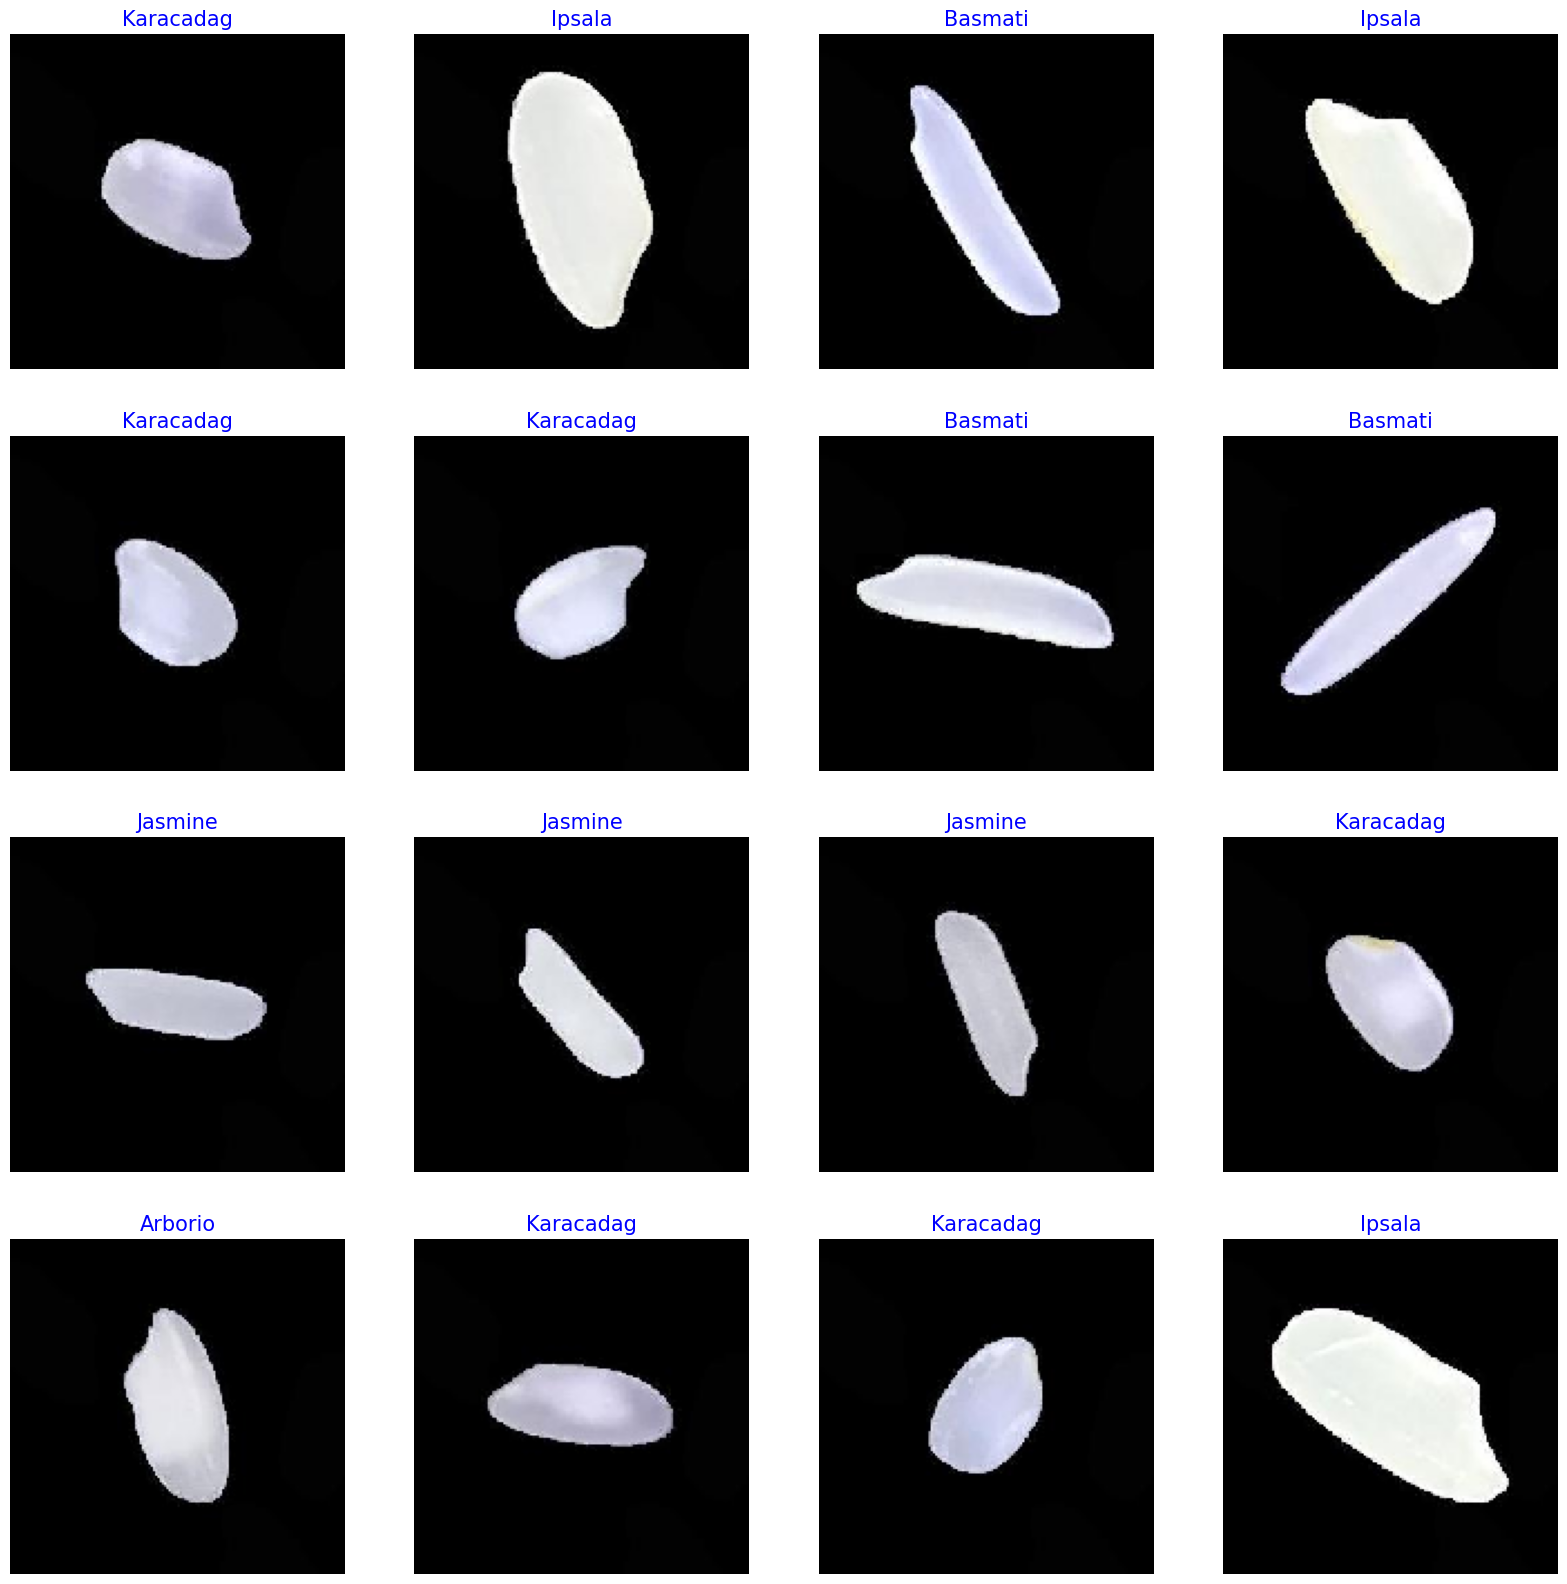

In [10]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))
for i in range(16):
    plt.subplot(4,4 , i +1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i])
    plt.title(classes[index], color= 'blue', fontsize= 15)
    plt.axis('off')
plt.show();

## Model Structure

In [11]:
img_shape= (img_size[0] , img_size[1] , channels)
class_count= len(classes)
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top= False, weights= 'imagenet',input_shape= img_shape,
                                                              pooling= 'max')
base_model.trainable= False

model= Sequential([
    base_model,
    BatchNormalization(axis= -1,momentum=0.99,epsilon=0.001),
    Dense(256, activation= 'relu'),
    Dropout(rate= 0.2 , seed= 123),
    Dense(class_count, activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
model.summary()

258076736/258076736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                       

In [13]:
checkpoint_path = "./cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

num_epochs= 10
history= model.fit(x= train_gen , validation_data= valid_gen, epochs= num_epochs, verbose= 1, validation_steps= None , 
                   shuffle= False,callbacks=[cp_callback])

Epoch 1/10
821/821 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9702
Epoch 1: saving model to ./cp.ckpt
821/821 [==============================] - 481s 586ms/step - loss: 0.0881 - accuracy: 0.9702 - val_loss: 0.0329 - val_accuracy: 0.9897
Epoch 2/10
821/821 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.9822
Epoch 2: saving model to ./cp.ckpt
821/821 [==============================] - 339s 413ms/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0293 - val_accuracy: 0.9910
Epoch 3/10
821/821 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9851
Epoch 3: saving model to ./cp.ckpt
821/821 [==============================] - 339s 412ms/step - loss: 0.0434 - accuracy: 0.9851 - val_loss: 0.0206 - val_accuracy: 0.9928
Epoch 4/10
821/821 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9872
Epoch 4: saving model to ./cp.ckpt
821/821 [==============================] - 339s 413ms/step - loss: 0.03

## Model Performance

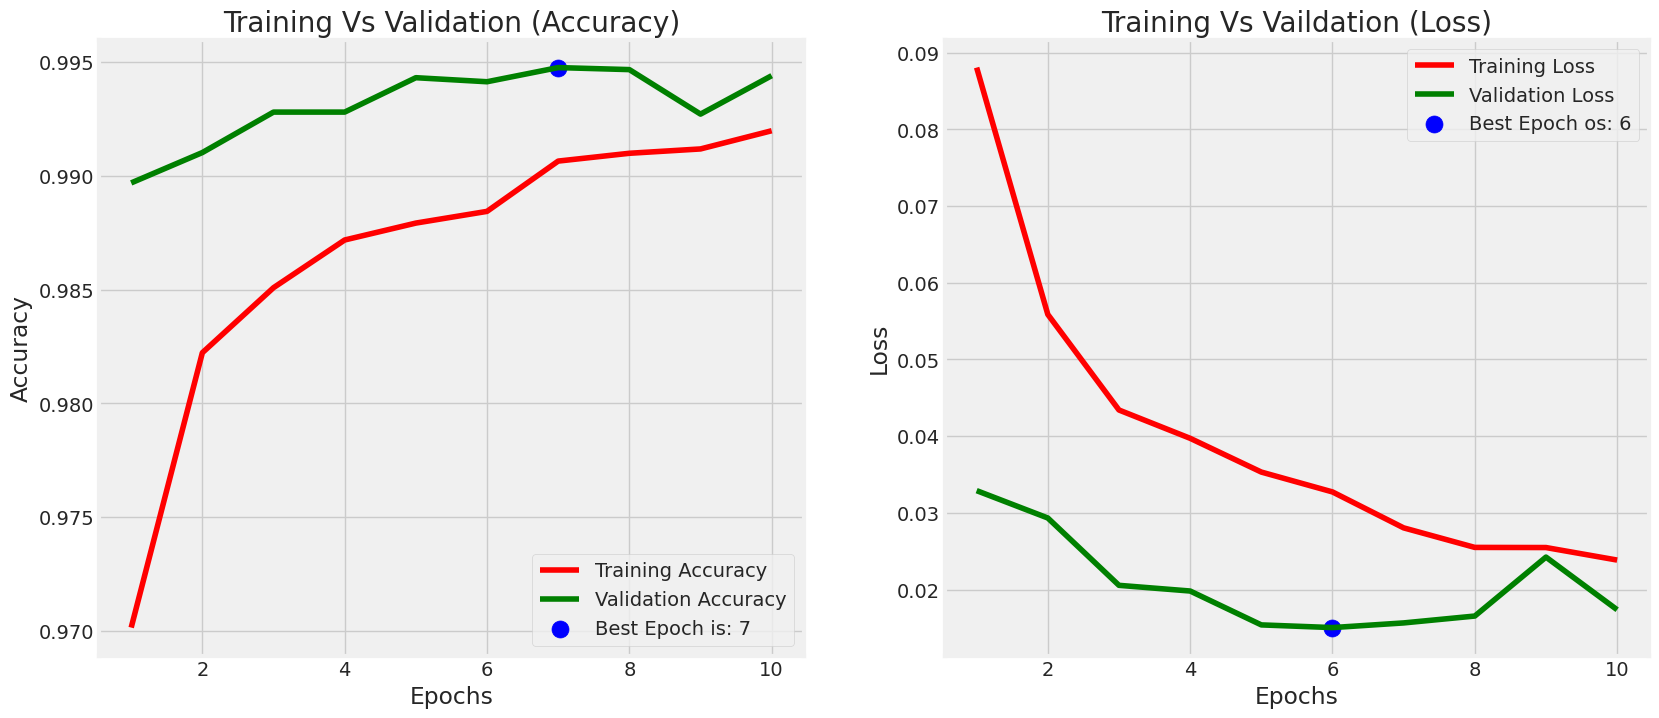

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc= np.argmax(val_acc)

val_lowest= val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs= [i+1 for i in range(len(train_acc))]
acc_label = f"Best Epoch is: {str(index_acc +1)}"
loss_label = f"Best Epoch os: {str(index_loss +1)}"

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= "Training Accuracy")
plt.plot(epochs , val_acc , 'g' , label= "Validation Accuracy")
plt.scatter(index_acc +1 ,val_highest , s = 150 , c= 'blue', label= acc_label)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label= "Training Loss")
plt.plot(epochs , val_loss , 'g' , label= "Validation Loss")
plt.scatter(index_loss +1 , val_lowest , s= 150 , c = 'blue' , label= loss_label)
plt.title("Training Vs Vaildation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

## Model Evaluation

In [15]:
train_score = model.evaluate(train_gen , steps =64 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 64 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 64 , verbose = 1)

64/64 [==============================] - 42s 654ms/step - loss: 0.0271 - accuracy: 0.9932


In [16]:
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

Train Loss:  0.010932935401797295
Train Accuracy:  0.99755859375
--------------------
Validation Loss:  0.018184419721364975
Validation Accuracy:  0.9951171875
--------------------
Test Loss:  0.027137376368045807
Test Accuracy:  0.9931640625


## Model Prediction

### 1-Confution Matrix

In [17]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

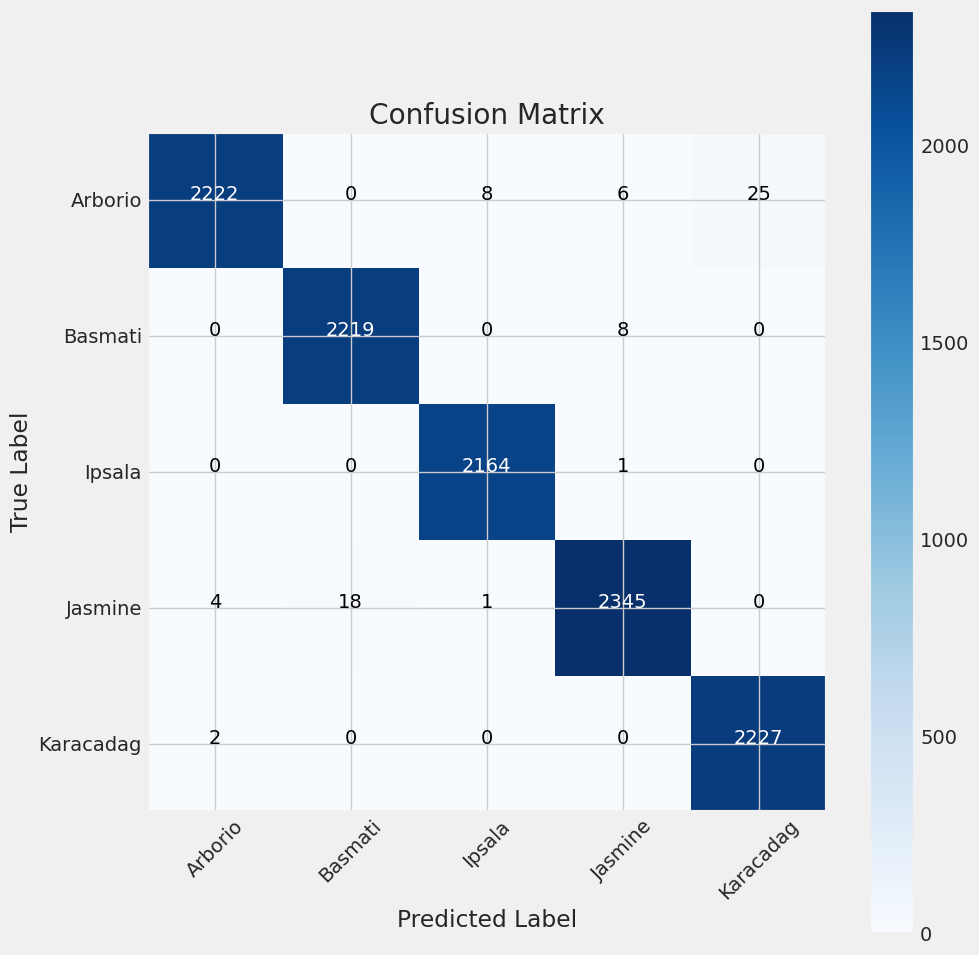

In [18]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### 2-Classification Report

In [19]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

     Arborio       1.00      0.98      0.99      2261
     Basmati       0.99      1.00      0.99      2227
      Ipsala       1.00      1.00      1.00      2165
     Jasmine       0.99      0.99      0.99      2368
   Karacadag       0.99      1.00      0.99      2229

    accuracy                           0.99     11250
   macro avg       0.99      0.99      0.99     11250
weighted avg       0.99      0.99      0.99     11250

